In [ ]:
! conda install -q -c conda-forge gdcm -y

In [ ]:
from fastai.vision.all import *

In [ ]:
datapath = Path("../input/siim-covid19-detection/")
image_df = pd.read_csv(datapath/'train_image_level.csv')
study_df = pd.read_csv(datapath/'train_study_level.csv')
sample_sub_df = pd.read_csv(datapath/'sample_submission.csv')

### A brief look at data

In [ ]:
image_df.shape, study_df.shape, sample_sub_df.shape

In [ ]:
image_df.head()

In [ ]:
study_df.head()

In [ ]:
sample_sub_df.head()

In [ ]:
assert len(sample_sub_df['id'].unique()) == sample_sub_df.shape[0]

**Number of images per study**

Most studies only have 1 image

In [ ]:
image_counts = Counter(image_df.groupby("StudyInstanceUID")["id"].apply(lambda o: len(list(o)))); print(image_counts)
x,h=list(zip(*image_counts.items()))
fig,ax=plt.subplots(1,1);ax.bar(x,h); ax.set_xticks(x);

**Study labels are mutually exclusive**

Each study has exactly 1 label, e.g. `negative|typical|indeterminate|atypical` don't coexist

In [ ]:
assert (study_df.iloc[:,1:].sum(1)==1).all()

**Distribution of classes in studies**

What are the detailed descriptions of each label? What does it mean to be `typical`?

In [ ]:
pd.DataFrame(study_df.iloc[:,1:].value_counts(),columns=['count'])

Let's merge study and image data

In [ ]:
study_df['StudyInstanceUID'] = study_df['id'].apply(lambda o: o[:-6])
merged_df = image_df.merge(study_df.drop('id',1),how='left',on='StudyInstanceUID')
merged_df["num_images"] = merged_df["StudyInstanceUID"].map(merged_df.groupby('StudyInstanceUID').apply(lambda o: len(o)))
merged_df.head()

We can see that study level predictions requires consideration of all images as expected

In [ ]:
merged_df.sort_values("num_images", ascending=False).head(10)

### What are Boxes and Labels?

What is in `label` that is not present in `boxes`, do we need `label` column at all?

In [ ]:
def proc_labels(labels):
    if isinstance(labels,str):
        res = []
        for l in list(chunked(labels.split(), chunk_sz=6)):
            class_label, conf, bb = l[0], eval(l[1]), array(l[2:],dtype=np.float)
            res.append([class_label, conf, bb])
        return res
    else: return

In [ ]:
merged_df.head(3)

In [ ]:
bboxes = [eval(o) if isinstance(o,str) else o for o in merged_df['boxes'].values]; bboxes[:3]

In [ ]:
labels = merged_df['label'].apply(proc_labels).values; labels[:3]

We can see that `boxes` have x1,y1 (upper left coordinate) and width and height information. `labels` have `x1,y1,x2,y2` coordinate format which can be constructed from `x1,x2,x1+width,y1+height`. This means during submission we will use `x1,y1,x2,y2` format.

In [ ]:
array([bboxes[0][0]['x'], bboxes[0][0]['y'], bboxes[0][0]['x'] + bboxes[0][0]['width'], bboxes[0][0]['y'] + bboxes[0][0]['height']]), labels[0][0]

We can see that all bounding boxes are labeled as `opacity` in `label` if not `none`.

In [ ]:
class_label_pat = '[a-zA-Z]+'
def get_class_labels(s): return re.findall(class_label_pat,s)
unique_class_labels = np.unique(np.concatenate(merged_df['label'].apply(get_class_labels)))

In [ ]:
unique_class_labels

### Understanding Submission

We are expected to make prediction for each study for each finding if there is any:

There are 4 possible classes: "negative", "typical", "indeterminate", "atypical"

- If there are no findings for a given study we will submit: `none 1 0 0 1 1` 

- If there are any findings for a given study we will submit `negative|typical|indeterminate|atypical <confidence> <x1,y1,x2,y2>`

At image level data we only have `opacity` label if there is a bounding box annotation, which doesn't tell us much. For accessing labels we need to use the study level labels. 

Below we can see that each study has exactly 1 label so maybe there is no notion of `No Finding` similar to the other CXR (Chest X-Ray) datasets such as Chexpert.

In [ ]:
assert (study_df.sum(1)==1).all()

Let's see if `negative` classes have any bboxes, if not maybe that is what meant by no finding. 

All negative studies indeeed have `none 1 0 0 1 1` as their labels. I am not a medical expert but I assume we can expect to see bbox annotations of an opacity which can be a negative case of pneumonia. 

Although, in training dataset we don't have any such cases. This is an important information for the formulation of the problem.

In this case are we going to submit a study with `Negative for Pneumonia == 1` as `none 1 0 0 1 1` or `negative 1 0 0 1 1`?

In [ ]:
merged_df[merged_df['Negative for Pneumonia'] == 1]['label'].unique()

Let's check if all non-negative e.g. `Negative for Pneumonia == 0` studies have a bounding box annotation.

In [ ]:
non_negative = merged_df[merged_df['Negative for Pneumonia'] == 0]
posstudy2boxes = dict(non_negative.groupby("StudyInstanceUID")['boxes'].apply(list))

nonnegative_studies_without_bboxes = []
for k in posstudy2boxes:
    v = posstudy2boxes[k]
    if len(v) == 1:
        if not isinstance(v[0],str): nonnegative_studies_without_bboxes.append(k)

There are 82 non negative without any bounding box.

In [ ]:
merged_df.query(f"StudyInstanceUID == {nonnegative_studies_without_bboxes}")

In [ ]:
merged_df.query(f"StudyInstanceUID == {nonnegative_studies_without_bboxes}").iloc[:,-5:-1].value_counts()

To summarize, we can cosntruct this problem as an object detection problem with class labels `typical|indeterminate|atypical` since we don't have any bounding box annotations for `negative` cases. Additionally we can also predict a `no object|no finding|negative` similar to DETR. This framing is only possible since we don't have negative bounding boxes, e.g. an opacity localization with label `negative`. In general, we can use any object detection framework and decide not to predict an object if confidence is very low based on a thresholding startegy, in that case we can output `none 1 0 0 1 1` or `negative 1 0 0 1 1`. More clarification is needed on this.


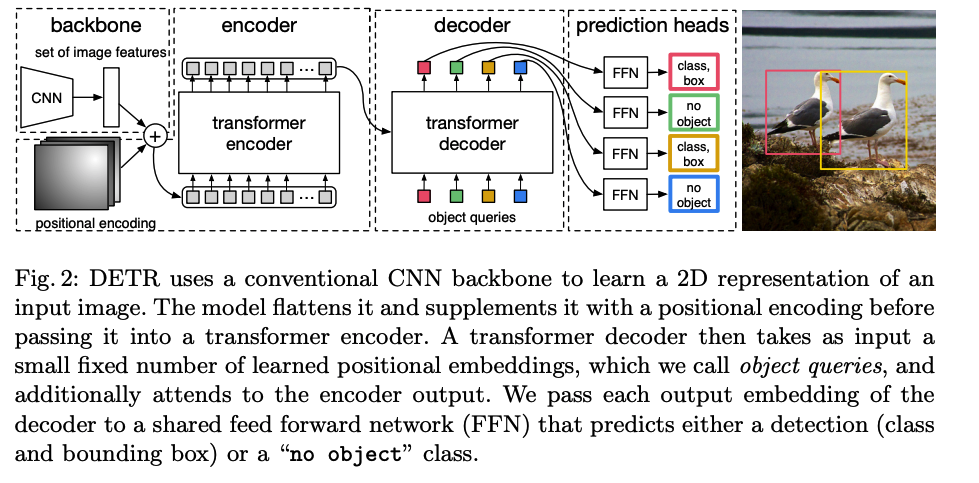


In [ ]:
study_df.query("id=='ff0879eb20ed_study'")

In [ ]:
merged_df.query("StudyInstanceUID == 'ff0879eb20ed'")

Note that for studies with more than 1 image, we need to predict the union, e.g. if there exists at least one positve bounding box prediction with either `typical|indeterminate|atypical` finding then submission can't be `negative` or `none`.

### Let's Visualize

Now that we know the format of the bboxes we can visualize few examples

In [ ]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import ImageOps
from matplotlib import patches

In [ ]:
trainfiles = get_files(datapath/"train", extensions=".dcm")
image_id2fname = {o.stem:o for o in trainfiles}
assert len(image_id2fname) == len(image_df) # no overlapping image ids in different studies

In [ ]:
next(iter(image_id2fname.items()))

#### A. Study with a single image and pneumonia

In [ ]:
#from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def read_xray(path, voi_lut = True, fix_monochrome = True, equalize=False):
    dicom = pydicom.read_file(path)

    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    # add equalization similar to MIMIC-CXR JPG
    img = Image.fromarray(data, mode='L')
    if equalize: img = ImageOps.equalize(img)
    return img

In [ ]:
random_study_id = merged_df[merged_df['Negative for Pneumonia']==0].query("num_images == 1")['StudyInstanceUID'].sample(1).values[0]
row = merged_df.query(f"StudyInstanceUID == '{random_study_id}'");row

In [ ]:
row_arr = array(row)[0]
image_id, bboxes, labels = row_arr[0][:-6], eval(row_arr[1]), proc_labels(row_arr[2])

Here, we access the `.pixel_array` the image from the dicom dataset, do min-max normalization, convert the image to unsigned integer and finally apply histogram equalization to enhance the contrast.

In [ ]:
img     = read_xray(image_id2fname[image_id], voi_lut=False)
img_voi = read_xray(image_id2fname[image_id], voi_lut=True)
img_eq  = read_xray(image_id2fname[image_id], voi_lut=True, equalize=True)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(20,7))
ax[0].imshow(img.to_thumb(360),cmap='gray');     ax[0].set_title("original")
ax[1].imshow(img_voi.to_thumb(360),cmap='gray'); ax[1].set_title("voi lut");
ax[2].imshow(img_eq.to_thumb(360),cmap='gray');  ax[2].set_title("hist eq");

In [ ]:
bboxes, labels

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img_eq,cmap='gray')
for bb in bboxes: 
    lx,ly,w,h, = bb['x'],bb['y'], bb['width'], bb['height']
    ax.add_patch(patches.Rectangle((lx,ly), w, h, fill=False, edgecolor='red', lw=2))

#### B. Study with multiple images and pneumonia

In [ ]:
random_study_id = merged_df[merged_df['Negative for Pneumonia']==0].query("num_images > 1")['StudyInstanceUID'].sample(1).values[0]
rows = merged_df.query(f"StudyInstanceUID == '{random_study_id}'");rows

In [ ]:
fnames = [image_id2fname[o[:-6]] for o in rows['id'].values]
imgs   = [read_xray(o,equalize=True) for o in fnames]
bboxes = [eval(o) if isinstance(o,str) else o for o in rows['boxes'].values]
labels = list(proc_labels(o) for o in rows['label']) # xmin,ymin,xmax,ymax

In [ ]:
fnames,bboxes, labels

For a given study, images without bounding box annotations look very similar to the image that is annotated. What does this tell us? Are they free of abnormality or they are just not annotated? Disclaimer: I am not a medical expert so I hope someone can explain further.

In [ ]:
fig,axes = plt.subplots(1,len(imgs),figsize=((len(imgs))*7, 15))
axes = axes.flatten()
for fn,im,bbs,ax in zip(fnames, imgs,bboxes,axes):
    ax.imshow(im,cmap='gray')
    ax.set_title(fn.name)
    if isinstance(bbs,list):
        for bb in bbs: 
            lx,ly,w,h, = bb['x'],bb['y'], bb['width'],bb['height']
            ax.add_patch(patches.Rectangle((lx,ly), w, h, fill=False, edgecolor='red', lw=2))